# Model of a production complex
Consider $N$ oil fields or reservoirs ($i$ = $1,2,...,N$) which are producing at rates $Q_i(t)$ where $t$ is the time. The total production of the $N$ reservoirs is to be adjusted to meet a commitment $Q_c(t)$ (such as keeping a pipe line full or a refinery supplied). An outside source of crude oil is also available. Let the profit realizable per barrel be $c_i(t)$ and consider that the operation is to be run on this basis for a period of $T$ years. Production limitations exist which require that the $Q_i(t)$ do not exceed certain values. These limits may be functions of the time. We shall consider the case where these fields are relatively young so that development drilling activity will occur during the time period under consideration. The problem is to determine a schedule of $Q_i(t)$ such that the profit over $T$ years is a maximum.

A complicating factor in this situation is the following: consider that during a certain time period, $Q_{i,j}$ was at level "A" and that in the succeeding time period $Q_{i,j+1}$ has dropped to level "B". The profit at level "B" is not obtained by following the profit line to operating level "B" but rather by following a line as shown which is parallel to the revenue line. The reduction in level from "A" to "B" involves merely turning a few valves and essentially does not entail any reduction in operating costs. If, on the other hand, we go from "A" to "C" in succeeding time periods, then we do follow the profit line because an increase in production necessitates drilling additional wells assuming that all the wells at "A" are producing at maximum economic capacity. If we should go from "A" to "B" to "C" in succeeding time periods and if "A" was the maximum field development up to that time, then in going from "B" to "C" we would follow the broken path.

So now let's have a look on how to solve this. First, we initialize and import what we need:
## Initialization and data import

In [1]:
from docplex.mp.model import Model
import math
import numpy as np
import matplotlib.pyplot as plt
from sys import stdout
mdl = Model("Oil production")

# Some useful functions
def getSinus(vector,constant,multiply,amplitude):
    return constant + multiply*np.sin(vector/amplitude)
def getRepeatSinus(vector,constant,multiply,amplitude,N):
    current = getSinus(vector,constant,multiply,amplitude)
    return np.transpose(np.repeat(current[:,np.newaxis], N, axis=1))

# Now the data
N = 4
T = 50
NRange = range(N)
TRange = range(T)
TLin = np.linspace(0,49,50)
QDemand = getSinus(TLin,5000,1000,10)
Qmax = getRepeatSinus(TLin,3000,1000,8,N)
cRevenue = getRepeatSinus(TLin,200,40,16,N)
cCost = 79*np.ones((N,T))
c = cRevenue - cCost

## Variable definition
We are interested in getting the flows from $N$ different wells for $T$ time steps. We therefore introduce $Q_{i,j}$ as our main variable.

Note that it is always a good idea to explicity state your bounds, just to avoid the solver making default assumptions.

In [2]:
Q = mdl.continuous_var_matrix(keys1=N,keys2=T,name='Q',lb=0)
mdl.add_constraints([Q[i,j] <= Qmax[i,j] for i in NRange for j in TRange]);

However, we will see now that due to the objective function we need some auxiliary variables. For the case of $Q_{i,j+1}$, we can write the following relationship:
\begin{equation}
Q_{i,j+1} = Q_{i,j} + \Delta q_{i,j}
\end{equation}
If we now want to find out the cost relationship for $Q_{i,j+1}$, we first consider that at $Q_{i,j}$, we earn $c_{i,j}Q_{i,j}$, which also holds for $Q_{i,j}$. Thus, we only have to consider the change in earnings due to $\Delta q_{i,j}$. To mirror the $<$ and $>$ conditions, we introduce the following two variables:
- $\Delta q_{i,j}^+$: The positive change of the production
- $\Delta q_{i,j}^-$: The negative change of the production

This immediately leads to:
\begin{equation}
\Delta q_{i,j} = \Delta q_{i,j}^+ + \Delta q_{i,j}^-
\end{equation}
with $\Delta q_{i,j}^+ \geq 0$ and $\Delta q_{i,j}^- \leq 0$. For each of these terms we know the profit terms though:
\begin{equation}
c_{i,j+1}Q_{i,j+1} = c_{i,j}Q_{i,j} + c_{i,j}\Delta q_{i,j}^+ + c_{i,j}^{\text{revenue}}\Delta q_{i,j}^-
\end{equation}

Therefore, let us define the relevant variables and relationships.

In [3]:
qPlus = mdl.continuous_var_matrix(keys1=N,keys2=T-1,lb=0,ub=np.max(Qmax),name='q+')
qMinus = mdl.continuous_var_matrix(keys1=N,keys2=T-1,lb=-np.max(Qmax), ub = 0, name='q-')

# Add the relationship constraint
mdl.add_constraints([Q[i,j+1] - Q[i,j] == qPlus[i,j] + qMinus[i,j],'Auxiliary for (%s,%s)' % (i,j)]
                    for i in NRange for j in TRange if j < T - 1);

## The objective function
Since we are at it, let us also define objective function. Note that for the very first flow $Q_{i,0}$ we do not have any $\Delta q$ and therefore we only use $c_{i,0}$.

In [4]:
mdl.maximize(mdl.sum(Q[i,j] + c[i,j]*Q[i,j] + c[i,j]*qPlus[i,j] + cRevenue[i,j]*qMinus[i,j] 
                     for i in NRange for j in TRange if j < T - 1)
             + mdl.sum(c[i,0]*Q[i,0] for i in NRange))

## The constraints
The main costraint we have is that we have to satisfy the demand. However, if we write (as we commonly do) $\geq$ for the demand constraint, then the optimization problem will just produce as much oil as possible with no regards for the demand, as the profit is positive.

Therefore, we write $==$ as a constraint sign. This is one of the reason I personally prefer minmizing cost rather than maximizing profit, as the models tend to behave "nicer".

In [5]:
mdl.add_constraints([mdl.sum(Q[i,j] for i in NRange) == QDemand[j],
                     'Demand satisfaction at time step %s' %j] for j in TRange) ;

## Solving a looking at the solution
Let's have a look:

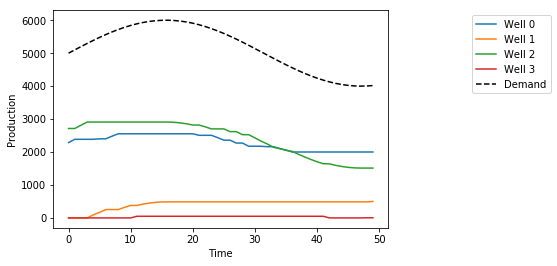

In [6]:
mdl.solve()

QVal = [[mdl.solution.get_value(Q[i,j]) for i in NRange] for j in TRange]
for n in NRange:
    plt.plot(TRange,np.transpose(QVal)[n],label='Well %s' %n)
plt.plot(TRange,QDemand,'k--',label="Demand")
plt.xlabel('Time')
plt.ylabel('Production')
plt.legend(bbox_to_anchor=(1.5, 1));

Also, let's have a look at the $q^+$ and $q^-$:

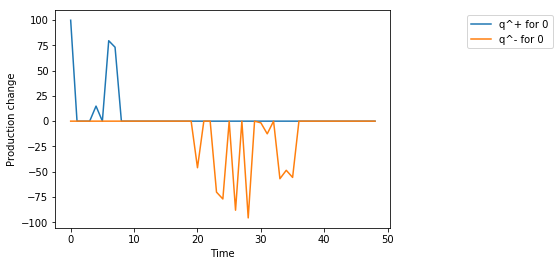

In [7]:
QPlus = [[mdl.solution.get_value(qPlus[i,j]) for i in NRange] for j in TRange if j < T - 1]
QMinus = [[mdl.solution.get_value(qMinus[i,j]) for i in NRange] for j in TRange if j < T - 1]

# Select a given n
n = 0
plt.plot(range(T-1),np.transpose(QPlus)[n],label='q^+ for %s' %n)
plt.plot(range(T-1),np.transpose(QMinus)[n],label='q^- for %s' %n)
plt.xlabel('Time')
plt.ylabel('Production change')
plt.legend(bbox_to_anchor=(1.5, 1));

## Changing the cost function
Now we look at the following cost functions for the different wells:
- $c_{1,j}^{\text{cost}} = 79 + 30\sin(j/11) \frac{\$}{\text{m}^3}$
- $c_{2,j}^{\text{cost}} = 90 + 10\sin(j/9) \frac{\$}{\text{m}^3}$
- $c_{3,j}^{\text{cost}} = 60 + 50\sin(j/18) \frac{\$}{\text{m}^3}$
- $c_{4,j}^{\text{cost}} = 79 \frac{\$}{\text{m}^3}$

How does that look like?

In [8]:
cCost = np.stack((getSinus(TLin,79,30,11),getSinus(TLin,90,10,9),getSinus(TLin,60,50,18),95*np.ones(T)))
c = cRevenue - cCost

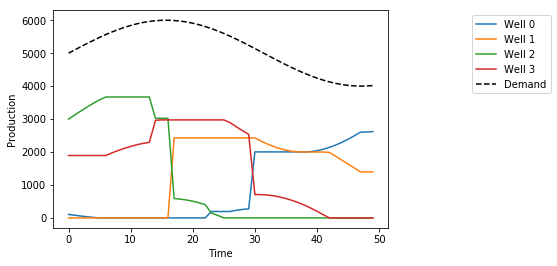

In [23]:
mdl = Model("Oil production")
Q = mdl.continuous_var_matrix(keys1=N,keys2=T,name='Q',lb=0)
mdl.add_constraints([Q[i,j] <= Qmax[i,j] for i in NRange for j in TRange]);
        
qPlus = mdl.continuous_var_matrix(keys1=N,keys2=T-1,lb=0,ub=np.max(Qmax),name='q+')
qMinus = mdl.continuous_var_matrix(keys1=N,keys2=T-1,lb=-np.max(Qmax), ub = 0, name='q-')

# Add the relationship constraint
mdl.add_constraints([Q[i,j+1] - Q[i,j] == qPlus[i,j] + qMinus[i,j],'Auxiliary for (%s,%s)' % (i,j)]
                    for i in NRange for j in TRange if j < T - 1);
mdl.maximize(mdl.sum(Q[i,j] + c[i,j]*Q[i,j] + c[i,j]*qPlus[i,j] + cRevenue[i,j]*qMinus[i,j] 
                     for i in NRange for j in TRange if j < T - 1)
             + mdl.sum(c[i,0]*Q[i,0] for i in NRange))
mdl.add_constraints([mdl.sum(Q[i,j] for i in NRange) == QDemand[j],
                     'Demand satisfaction at time step %s' %j] for j in TRange) ;
mdl.solve()

objectiveFunctionValue = mdl.solution.get_objective_value()
QVal = [[mdl.solution.get_value(Q[i,j]) for i in NRange] for j in TRange]
for n in NRange:
    plt.plot(TRange,np.transpose(QVal)[n],label='Well %s' %n)
plt.plot(TRange,QDemand,'k--',label="Demand")
plt.xlabel('Time')
plt.ylabel('Production')
plt.legend(bbox_to_anchor=(1.5, 1));

## Investment decision
Finally, we look at the question of how much it would save to add a storage tank: if we had a storage tank, we would describe that as follows:
- The volume in the tank at time $j$: $V_j$ with $0 \leq V_j \leq V_{tot}$
- The flow in/out of the tank at time $j$: $q_j^{\text{storage}}$
- The relationship between the two: $V_j = \sum \limits_{k=0}^{j} q_k^{\text{storage}}$

Lastly, we have to augment the demand satisfaction with the storage:
\begin{equation}
q_j^{\text{storage}} = Q_{c,j} - \sum \limits_i Q_{i,j}
\end{equation}
i.e. everything that does not satisfy the demand will go into storage.

Text(0,0.5,'Objective function value')

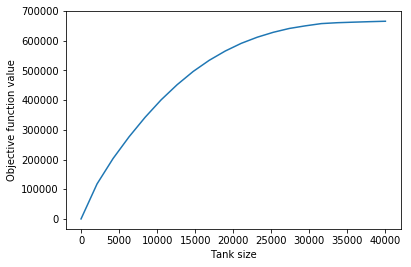

In [41]:
cCost = np.stack((getSinus(TLin,79,30,11),getSinus(TLin,90,10,9),getSinus(TLin,60,50,18),95*np.ones(T)))
c = cRevenue - cCost

VMin = 0;
VMax = 40000;
VAll = np.linspace(VMin,VMax,20)
objValue = np.zeros(len(VAll))
count = 0

for v in VAll:
    Vtot = v
    mdl = Model("Oil production")
    Q = mdl.continuous_var_matrix(keys1=N,keys2=T,name='Q',lb=0)
    mdl.add_constraints([Q[i,j] <= Qmax[i,j] for i in NRange for j in TRange])
        
    qPlus = mdl.continuous_var_matrix(keys1=N,keys2=T-1,lb=0,ub=np.max(Qmax),name='q+')
    qMinus = mdl.continuous_var_matrix(keys1=N,keys2=T-1,lb=-np.max(Qmax), ub = 0, name='q-')
    V = mdl.continuous_var_list(T,lb=0,ub=Vtot,name='V')
    qStore = mdl.continuous_var_list(T,lb=-np.max(Qmax),ub=np.max(Qmax),name='qStore')

    # Add the relationship constraint
    mdl.add_constraints([Q[i,j+1] - Q[i,j] == qPlus[i,j] + qMinus[i,j],'Auxiliary for (%s,%s)' % (i,j)]
                    for i in NRange for j in TRange if j < T - 1);
    mdl.add_constraints([V[j] == mdl.sum(qStore[k] for k in range(j+1)), 'Storage balance at time %s' % j] for j in TRange);

    mdl.maximize(mdl.sum(Q[i,j] + c[i,j]*Q[i,j] + c[i,j]*qPlus[i,j] + cRevenue[i,j]*qMinus[i,j] 
                     for i in NRange for j in TRange if j < T - 1)
             + mdl.sum(c[i,0]*Q[i,0] for i in NRange))

    mdl.add_constraints([mdl.sum(Q[i,j] for i in NRange) + qStore[j] == QDemand[j],
                     'Demand satisfaction at time step %s' %j] for j in TRange) ;
    mdl.solve()
    
    objValue[count] = mdl.solution.get_objective_value()
    count = count + 1

plt.plot(VAll,objValue - objectiveFunctionValue)
plt.xlabel('Tank size')
plt.ylabel('Objective function value');

Alternatively, we can also include a constraint that the gain has to be more than 500k and see when it becomes feasible. To do this exactly though (i.e. to solve for the decision itself) we would need mixed-integer programming (day 4).